In [71]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-sentiment-analysis/news_sentiment_analysis.csv


# **Import**

In [72]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from plotly.subplots import make_subplots
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

# **1. Data Import & EDA**

In [73]:
df = pd.read_csv('/kaggle/input/news-sentiment-analysis/news_sentiment_analysis.csv')

In [74]:
df.shape

(3500, 8)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Source        3500 non-null   object
 1   Author        2512 non-null   object
 2   Title         3500 non-null   object
 3   Description   3500 non-null   object
 4   URL           3500 non-null   object
 5   Published At  3500 non-null   object
 6   Sentiment     3500 non-null   object
 7   Type          3500 non-null   object
dtypes: object(8)
memory usage: 218.9+ KB


**Missing Value Check**

In [76]:
df.isnull().sum()

Source            0
Author          988
Title             0
Description       0
URL               0
Published At      0
Sentiment         0
Type              0
dtype: int64

**Duplicated value check**

In [77]:
df.duplicated().sum()

737

# **2. Data Transform**

In [78]:
df.dropna(axis=0,inplace=True)
df = df.drop_duplicates()

**Data Check**

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2002 entries, 0 to 2799
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Source        2002 non-null   object
 1   Author        2002 non-null   object
 2   Title         2002 non-null   object
 3   Description   2002 non-null   object
 4   URL           2002 non-null   object
 5   Published At  2002 non-null   object
 6   Sentiment     2002 non-null   object
 7   Type          2002 non-null   object
dtypes: object(8)
memory usage: 140.8+ KB


In [80]:
df.duplicated().sum()

0

In [81]:
df.head(2)

,Source,Author,Title,Description,URL,Published At,Sentiment,Type
0,stgnews,Bridger Palmer,Pine View High teacher wins Best in State awar...,"ST. GEORGE — Kaitlyn Larson, a first-year teac...",https://www.stgeorgeutah.com/news/archive/2024...,2024-07-12T23:45:25+00:00,positive,Business
1,Zimbabwe Mail,Staff Reporter,Businesses Face Financial Strain Amid Liquidit...,"Harare, Zimbabwe – Local businesses are grappl...",https://www.thezimbabwemail.com/business/busin...,2024-07-12T22:59:42+00:00,neutral,Business


# **3. Data Visualization**

## **CountPlot**

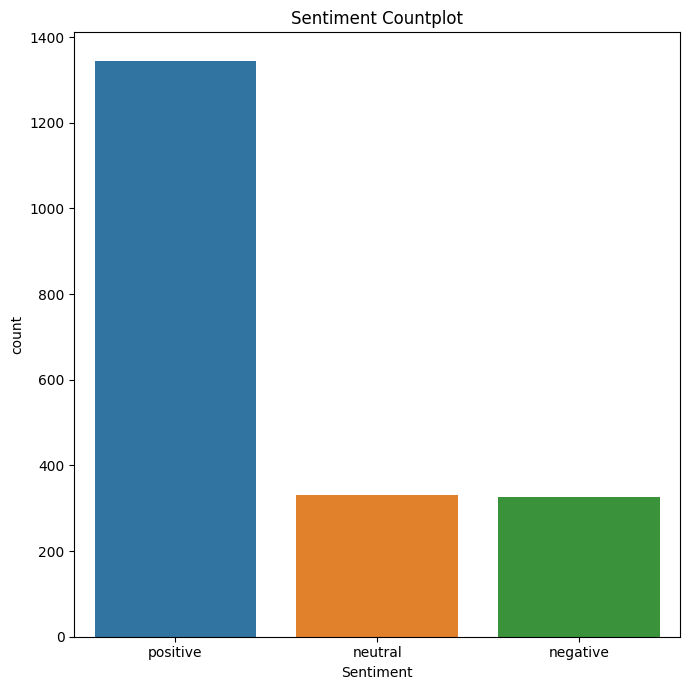

In [82]:
plt.subplots(figsize=(7, 7))
sns.countplot(df, x= 'Sentiment' )
plt.title('Sentiment Countplot')
plt.tight_layout()
plt.show() 

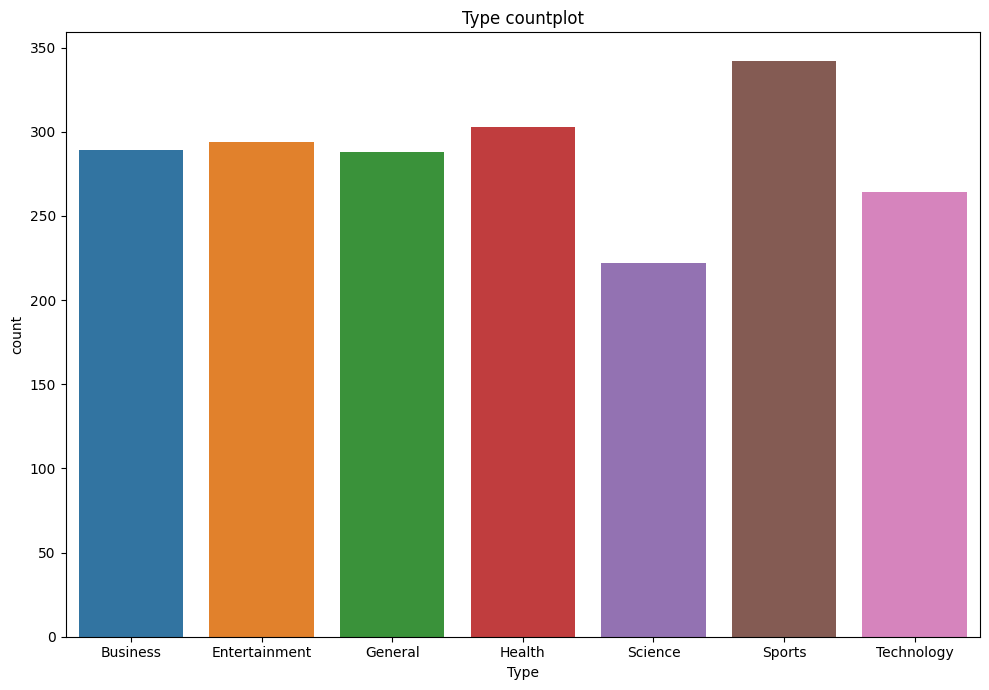

In [83]:
plt.subplots(figsize=(10, 7))
sns.countplot(df, x= 'Type')
plt.title('Type countplot')
plt.tight_layout()
plt.show() 

## **Text Length Distribution**

In [84]:
df['Description'] = df['Description'].fillna('')

df['text_length'] = df['Description'].apply(lambda x: len(str(x).split()))
fig = px.histogram(df, x='text_length', title='Text Length Distribution')
fig.show()

# **4. Modeling**

In [85]:
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## **Data Preprocessing**

In [86]:
nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    
    return text

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [87]:
df['cleaned_Description'] = df['Description'].apply(lambda x: preprocess_text(x))

In [88]:
df['cleaned_Description'] = df['cleaned_Description'].astype(str)

texts = df['cleaned_Description']
labels = df['Sentiment']

In [89]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

## **Train Test Split**

In [90]:
X_train, X_test, y_train, y_test = train_test_split(texts, encoded_labels, test_size=0.2, random_state=42, stratify = encoded_labels)

In [91]:
vectorizer = TfidfVectorizer(max_features=5000)  
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## **Modeling**

In [92]:
rfc = RandomForestClassifier(n_estimators = 300 , random_state=42)
lgr = LogisticRegression()
xgb = XGBClassifier(random_state=42)

models = [rfc, lgr, xgb]

names = ["Random Forest", "Logistic Regression", "XGBoost"]

Random Forest accuracy: 0.8279
              precision    recall  f1-score   support

    negative       0.97      0.42      0.59        66
     neutral       0.82      0.64      0.72        66
    positive       0.82      0.97      0.89       269

    accuracy                           0.83       401
   macro avg       0.87      0.68      0.73       401
weighted avg       0.84      0.83      0.81       401



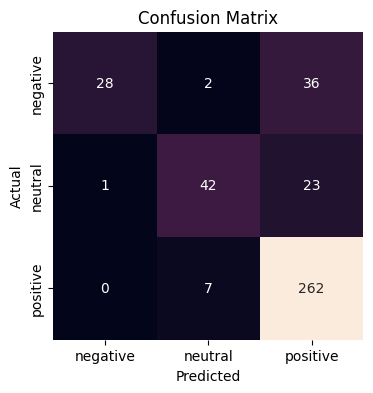

--------------------------------------------------
Logistic Regression accuracy: 0.7905
              precision    recall  f1-score   support

    negative       0.92      0.35      0.51        66
     neutral       0.88      0.45      0.60        66
    positive       0.77      0.98      0.86       269

    accuracy                           0.79       401
   macro avg       0.86      0.59      0.66       401
weighted avg       0.81      0.79      0.76       401



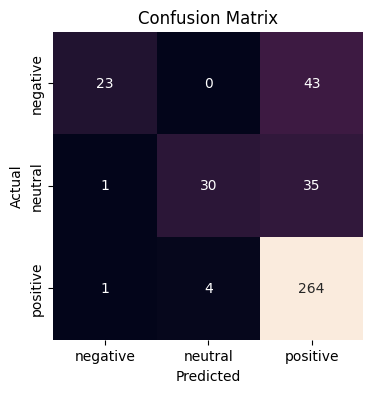

--------------------------------------------------
XGBoost accuracy: 0.8479
              precision    recall  f1-score   support

    negative       0.84      0.58      0.68        66
     neutral       0.74      0.79      0.76        66
    positive       0.87      0.93      0.90       269

    accuracy                           0.85       401
   macro avg       0.82      0.76      0.78       401
weighted avg       0.85      0.85      0.84       401



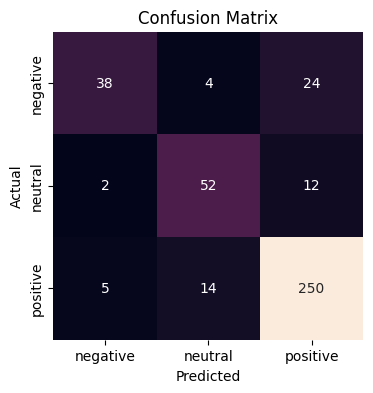

--------------------------------------------------


In [93]:
index = 0
ac = []

for name, model in enumerate(models):
    model.fit(X_train_tfidf, y_train)
    pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, pred)
    
    ac.append(accuracy)
    cm = confusion_matrix(y_test, pred)
    print(f'{names[index]} accuracy: {round(accuracy,4)}')
    print(classification_report(y_test, pred, target_names=label_encoder.classes_))
 
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.xticks([0.5, 1.5, 2.5], labels=['negative','neutral', 'positive'])
    plt.yticks([0.5, 1.5, 2.5], labels=['negative','neutral', 'positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    print("-"*50)
    
    index += 1

# **5. Evaluation**

In [94]:
acc_df = pd.DataFrame({'Model': names, 'Accuracy': ac})
acc_df['Accuracy'] = acc_df['Accuracy']*100
px.bar(acc_df , x= 'Accuracy', y='Model', text_auto = True,  title = 'Model Accuracy', orientation='h', template='plotly_dark')

**Thankyou. Please leave your advice in the comments**